In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import timeit

In [2]:
# Loading the cleaned dataset, in which within-mouse outliers have been removed and then the mean per mouse has been calculated
# Outlier biological replicates are still present.  Some mice are missing data for some proteins.
# (8/76 proteins are missing at least one data point.)
data = pd.read_csv('Data_Cortex_Nuclear_Means_Clean.csv')
# data1 will have all the protein level data in columns with the independent variables moved to the index
data1 = data.set_index(['Genotype','Behavior','Treatment'])
data1.drop(['class','Mouse'],axis = 1, inplace = True)
data.head()

,Genotype,Behavior,Treatment,class,Mouse,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,...,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,Control,C/S,Memantine,c-CS-m,309,0.421063,0.576510,0.356447,2.278252,4.354744,...,0.832559,0.192871,0.151524,NaN,0.115433,0.423088,0.136374,0.169300,0.169590,1.674160
1,Control,C/S,Memantine,c-CS-m,311,0.600591,0.678479,0.334548,2.277561,4.234706,...,0.673229,0.188092,0.166315,0.168952,NaN,0.426774,0.141512,0.201386,0.200284,1.193285
2,Control,C/S,Memantine,c-CS-m,320,0.547676,0.796012,0.398649,2.664515,5.498960,...,0.859745,0.218300,0.159284,0.138537,0.123580,0.538909,0.141971,0.187006,NaN,1.624791
3,Control,C/S,Memantine,c-CS-m,321,0.438728,0.652045,0.359441,2.686405,5.298355,...,0.922949,0.238123,NaN,0.158817,NaN,0.559531,0.150542,0.220306,NaN,1.678225
4,Control,C/S,Memantine,c-CS-m,322,0.358931,0.512223,0.315105,2.111664,4.231444,...,0.828905,0.239495,NaN,0.154224,0.141323,0.493076,NaN,NaN,NaN,1.607234


In [3]:
# Code to divide data into 2 parts by whichever variable

# A dictionary that identifies the labels used for the control group for each variable
variables_control_values = {'Genotype':  'Control', 
                            'Behavior':  'S/C', 
                            'Treatment': 'Saline'}

def split_data(variable):
    # Variable should be the column name identifying one of the 3 independent variables that 
    # divides the dataset into 8 groups.
    # The function returns 2 dataframes, representing the 2 subsets of data defined by that variable
    tag = variables_control_values[variable]
    group1_data = data.query(variable + ' == @tag')
    group2_data = data.query(variable + ' != @tag')
    return(group1_data, group2_data)

In [4]:
# Functions for performing bootstrap testing for differences in means
# On my system, 10,000 replicates takes about 1.1s per test, so don't use for large #s tests
def get_bootstrap_replicates(data, func=np.mean, size=10000):
    n = len(data)
    bootstrap_replicates = np.asarray([func(np.random.choice(data, n)) for i in range(size)])
    return bootstrap_replicates

def bootstrap_test_means(data1, data2, n_reps = 10000):
    group_mean = np.mean(np.concatenate((data1, data2)))
    data1_shifted = data1 - np.mean(data1) + group_mean
    data2_shifted = data2 - np.mean(data2) + group_mean
    mean_reps_1 = get_bootstrap_replicates(data1_shifted, func = np.mean, size = n_reps)
    mean_reps_2 = get_bootstrap_replicates(data2_shifted, func = np.mean, size = n_reps)
    bs_reps = mean_reps_1 - mean_reps_2
    obs_diff = np.mean(data1) - np.mean(data2)
    p_value = np.sum(np.abs(bs_reps) > np.abs(obs_diff))/n_reps
    return p_value

In [5]:
def multiple_comparison_correction(p_values, fdr = 0.05):
    # Given a numpy array of p-values and a desired false discovery rate,
    # uses the Benjamini–Hochberg procedure to correct for multiple comparisons.
    # Returns a boolean array where True indicates statistical significance of each
    # p-value and an array of the Q values that were used to compare the p-values.
    n_comparisons = len(p_values)
    p_ranks = stats.rankdata(p_values)
    q_values = p_ranks/n_comparisons*fdr
    cutoff = p_values[p_values < q_values]
    significant = np.asarray([False] * n_comparisons)
    if len(cutoff)>0:
        highest = max(cutoff)
        significant[p_values <= highest] = True
    return significant, q_values

Maximum number of comparisons = 3 variables * 76 proteins = 228

Minimum Q value = FDR * 1/228

For bootstrap replicates, I'd need enough replicates that I can calculate p_values close that are close to the minimum q_values; otherwise I'd get p = 0 when it may in fact be higher than the cutoff.

maximum n_reps s.t. expected # of more extreme values @ null = 10 is 228/FDR*10.

45600 with FDR = 0.05, 228,000 with FDR = 0.01

In [6]:
candidate_proteins = ['DYRK1A_N', 'ITSN1_N', 'CaNA_N',      'SOD1_N',   'pERK_N', 
                      'BRAF_N',   'GSK3B_N', 'pPKCAB_N',    'P38_N',    'pMTOR_N', 
                      'PSD95_N',  'SNCA_N',  'Ubiquitin_N', 'H3MeK4_N', 'EGR1_N']
all_proteins = data.columns[5:]

In [7]:
# Use t-tests as a quicker scan through comparisons, because while I have candidate proteins that should show
# significant differences between the learning and no learning conditions, I would like to find some clear effects of genotype
n_vars = len(variables_control_values)
n_proteins = len(all_proteins)
n_comparisons = n_vars * n_proteins

time0 = timeit.default_timer()
idx = 0
test_values = {'protein':     [''] * n_comparisons,
               'variable':    [''] * n_comparisons,
               'p_value':     np.empty(n_comparisons)}
               
for variable in variables_control_values.keys():
    control, experim = split_data(variable)
    for protein in all_proteins:
        start_time = timeit.default_timer()
        test_values['protein'][idx]  = protein
        test_values['variable'][idx] = variable
        group1 = control[protein].dropna()
        group2 = experim[protein].dropna()
        t, p = stats.ttest_ind(group1, group2, equal_var=False)
        test_values['p_value'][idx] = p
        idx += 1

total_time = timeit.default_timer() - time0
print('Total time for %d tests: %.2fs' %(n_comparisons, total_time))

Total time for 228 tests: 0.28s


In [8]:
test_values['significant'], test_values['q_value'] = multiple_comparison_correction(test_values['p_value'], fdr = 0.05)
test_values_df = pd.DataFrame(test_values)
candidates = test_values_df.loc[test_values_df['significant']]
candidates

,protein,variable,p_value,significant,q_value
30,APP_N,Genotype,1.091676e-09,True,0.001535
48,S6_N,Genotype,1.252708e-03,True,0.006579
76,DYRK1A_N,Behavior,1.103084e-05,True,0.003509
77,ITSN1_N,Behavior,1.092159e-05,True,0.003289
81,pAKT_N,Behavior,4.492839e-04,True,0.005482
82,pBRAF_N,Behavior,5.652242e-04,True,0.005702
83,pCAMKII_N,Behavior,3.084314e-06,True,0.002632
84,pCREB_N,Behavior,6.983710e-03,True,0.009211
85,pELK_N,Behavior,3.160518e-03,True,0.008772
86,pERK_N,Behavior,1.739426e-07,True,0.001754


Just as appeared from my clustering data, many proteins change levels with learning, but few have levels whose means are primarily affected by genotype or treatment.  Note that I have not looked for interactions here.

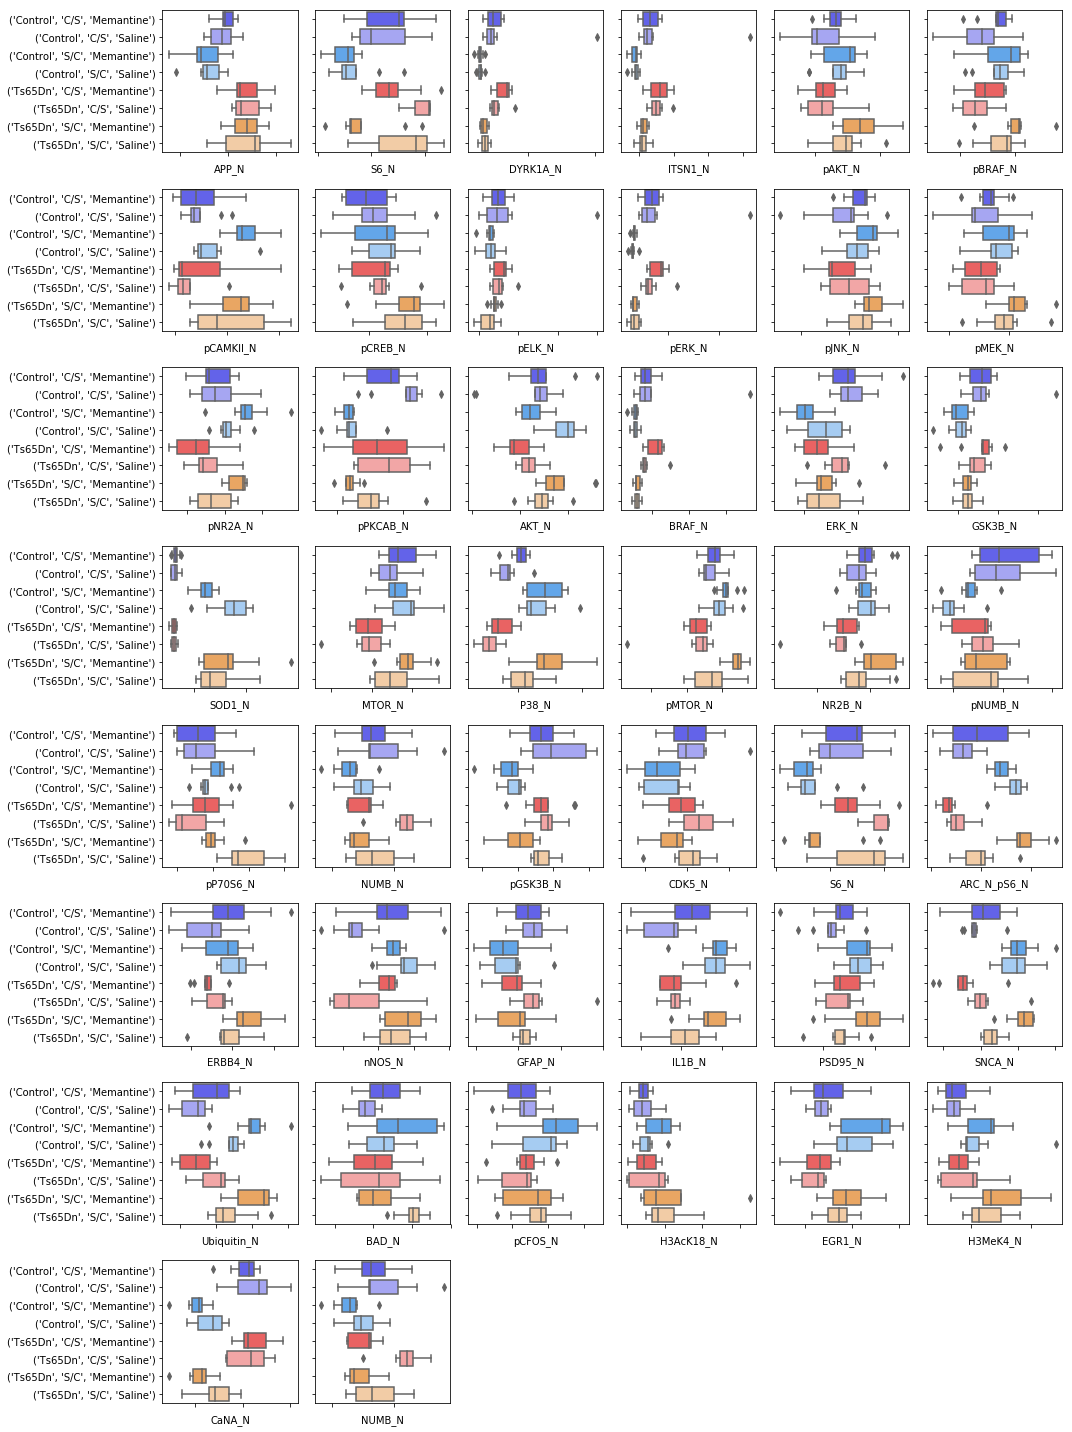

In [9]:
# visualize the differences identified by this screen
colors = [(0.3, 0.3,  1.0), (0.6, 0.6, 1.0), #Control genotype, Learning = dark blues; opaque = treated
          (0.3, 0.65, 1.0), (0.6, 0.8, 1.0), #Control genotype, No learning = light blues; opaque = treated
          (1.0, 0.3,  0.3), (1.0, 0.6, 0.6), #Down Syndrome, Learning = reds; opaque = treated
          (1.0, 0.65, 0.3), (1.0, 0.8, 0.6)] #Down Syndrome, No Learning = oranges; opaque = treated

plt.figure(figsize = (15,20))
plot_idx = 1
v_axes = []
data_i = data.set_index(['Genotype', 'Behavior', 'Treatment'])
for protein in candidates.protein:
    plt.subplot(8,6,plot_idx)
    v_axes.append(sns.boxplot(y = data_i.index, x = data_i[protein], palette = colors, notch = False))
    v_axes[plot_idx-1].set(xticklabels=[])
    if (plot_idx % 6) != 1:
        v_axes[plot_idx-1].set(yticklabels=[])
    plot_idx += 1
_ = plt.tight_layout()

In [10]:
# T-tests made assumptions that are probably not supported by the data.  
# Redo tests only on candidate proteins using bootstrapping
candidates2 = candidates.copy().drop(['p_value','q_value','significant'], axis = 1)
n_comparisons = len(candidates2.index)
time0 = timeit.default_timer()
n_reps = 50000
print('Minimum p-value that can be calculated:',1/n_reps)

def bs_mean_test(var_and_prot):
    start = timeit.default_timer()
    variable = var_and_prot[1]
    protein = var_and_prot[0]
    control, experim = split_data(variable)
    group1 = control[protein].dropna()
    group2 = experim[protein].dropna()
    p = bootstrap_test_means(group1, group2, n_reps)
    #print(timeit.default_timer() - start)
    return p

candidates2['p_value_bs'] = candidates2.apply(bs_mean_test, axis = 1)
total_time = timeit.default_timer() - time0

print('Total time for %d %d-rep tests: %.2fs' %(n_comparisons, n_reps, total_time))

candidates2['significant'], candidates2['q_value_bs'] = multiple_comparison_correction(candidates2['p_value_bs'], fdr = 0.01)
candidates2

Minimum p-value that can be calculated: 2e-05
Total time for 44 50000-rep tests: 215.48s


,protein,variable,p_value_bs,significant,q_value_bs
30,APP_N,Genotype,0.00000,True,0.001705
48,S6_N,Genotype,0.00050,True,0.006364
76,DYRK1A_N,Behavior,0.00006,True,0.004773
77,ITSN1_N,Behavior,0.00002,True,0.003864
81,pAKT_N,Behavior,0.00010,True,0.005341
82,pBRAF_N,Behavior,0.00028,True,0.005909
83,pCAMKII_N,Behavior,0.00000,True,0.001705
84,pCREB_N,Behavior,0.00488,True,0.009773
85,pELK_N,Behavior,0.00366,True,0.009318
86,pERK_N,Behavior,0.00002,True,0.003864


In [11]:
candidates2.sort_values('p_value_bs')

,protein,variable,p_value_bs,significant,q_value_bs
30,APP_N,Genotype,0.00000,True,0.001705
150,H3MeK4_N,Behavior,0.00000,True,0.001705
149,EGR1_N,Behavior,0.00000,True,0.001705
141,Ubiquitin_N,Behavior,0.00000,True,0.001705
140,SNCA_N,Behavior,0.00000,True,0.001705
129,ARC_N_pS6_N,Behavior,0.00000,True,0.001705
121,pGSK3B_N,Behavior,0.00000,True,0.001705
151,CaNA_N,Behavior,0.00000,True,0.001705
110,P38_N,Behavior,0.00000,True,0.001705
108,SOD1_N,Behavior,0.00000,True,0.001705


In [12]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [13]:
def anova_3way(protein):
    formula = protein + ' ~ C(Genotype) + C(Behavior) + C(Treatment)'
    formula += ' + C(Genotype):C(Behavior) + C(Genotype):C(Treatment) + C(Behavior):C(Treatment)'
    formula += ' + C(Genotype):C(Behavior):C(Treatment)'
    model = ols(formula, data).fit()
    aov_table = anova_lm(model, typ=2)
    return aov_table

In [14]:
a = anova_3way('NUMB_N')
effect_list = a.index[0:-1]
a

,sum_sq,df,F,PR(>F)
C(Genotype),0.000854,1.0,2.856319,0.095881
C(Behavior),0.004230,1.0,14.140658,0.000370
C(Treatment),0.003961,1.0,13.243647,0.000548
C(Genotype):C(Behavior),0.000225,1.0,0.753244,0.388694
C(Genotype):C(Treatment),0.000806,1.0,2.695760,0.105521
C(Behavior):C(Treatment),0.000206,1.0,0.687987,0.409933
C(Genotype):C(Behavior):C(Treatment),0.000664,1.0,2.220054,0.141140
Residual,0.019143,64.0,NaN,NaN


In [15]:
aov_results = pd.DataFrame(index = all_proteins,columns = effect_list)
for protein in all_proteins:
    aov_table = anova_3way(protein)
    aov_results.loc[protein] = aov_table['PR(>F)'][0:-1]
aov_results

,C(Genotype),C(Behavior),C(Treatment),C(Genotype):C(Behavior),C(Genotype):C(Treatment),C(Behavior):C(Treatment),C(Genotype):C(Behavior):C(Treatment)
DYRK1A_N,0.304586,2.91579e-06,0.774242,0.857949,0.342902,0.919356,0.265457
ITSN1_N,0.047022,2.43382e-06,0.624386,0.621065,0.345508,0.630078,0.496069
BDNF_N,0.618384,0.0996305,0.429408,0.0023213,0.389302,0.327711,0.813493
NR1_N,0.166782,0.874955,0.438595,0.0223183,0.0470516,0.569267,0.129409
NR2A_N,0.0354379,0.159855,0.87595,0.00149333,0.0732925,0.854869,0.098267
pAKT_N,0.409194,0.000380246,0.102665,0.0754919,0.980328,0.653636,0.265575
pBRAF_N,0.903999,0.000395977,0.0229725,0.165877,0.710202,0.80496,0.393977
pCAMKII_N,0.881467,1.87762e-06,0.0337846,0.630704,0.489136,0.311833,0.0535955
pCREB_N,0.0534641,0.00830839,0.396101,0.185411,0.513411,0.543536,0.727395
pELK_N,0.940469,0.00321078,0.940296,0.710418,0.205149,0.423415,0.960049


In [16]:
aov_results.columns = ['Genotype', 'Behavior', 'Treatment', 'Geno_Behav','Geno_Treat','Behav_Treat','Triple_Interact']

for c in aov_results.columns:
    aov_results[c] = pd.to_numeric(aov_results[c])
aov_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, DYRK1A_N to CaNA_N
Data columns (total 7 columns):
Genotype           76 non-null float64
Behavior           76 non-null float64
Treatment          76 non-null float64
Geno_Behav         76 non-null float64
Geno_Treat         76 non-null float64
Behav_Treat        76 non-null float64
Triple_Interact    76 non-null float64
dtypes: float64(7)
memory usage: 7.2+ KB


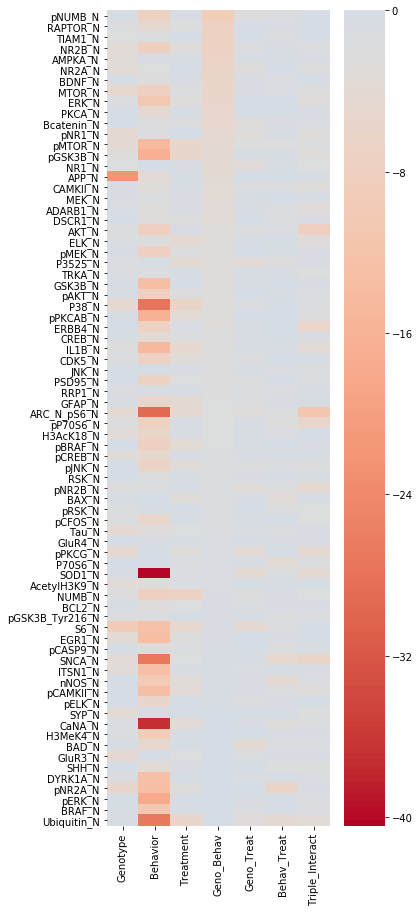

In [17]:
_ = plt.figure(figsize = [5,15])
log_p = aov_results.apply(np.log).sort_values('Geno_Behav')
_ = sns.heatmap(log_p, cmap='coolwarm_r', center = -2, vmax = 0)

In [18]:
(aov_results < 0.001).sum()

Genotype            2
Behavior           34
Treatment           1
Geno_Behav          4
Geno_Treat          0
Behav_Treat         0
Triple_Interact     2
dtype: int64

In [19]:
aov_results.Geno_Behav.loc[aov_results.Geno_Behav < 0.05].sort_values()

pNUMB_N       0.000093
RAPTOR_N      0.000490
TIAM1_N       0.000654
NR2B_N        0.000812
AMPKA_N       0.001096
NR2A_N        0.001493
BDNF_N        0.002321
MTOR_N        0.002322
ERK_N         0.002670
PKCA_N        0.004870
Bcatenin_N    0.005341
pNR1_N        0.010545
pMTOR_N       0.012619
pGSK3B_N      0.015046
NR1_N         0.022318
APP_N         0.022490
CAMKII_N      0.023793
MEK_N         0.025827
ADARB1_N      0.028979
DSCR1_N       0.036074
Name: Geno_Behav, dtype: float64

In [20]:
0.05/76

0.0006578947368421052

In [21]:
#alpha = 0.05/76
alpha = 0.01
sig = aov_results.loc[(aov_results < alpha).sum(axis = 1) > 0]
(sig < alpha).sort_values(['Genotype','Treatment','Behavior'], ascending = False)

,Genotype,Behavior,Treatment,Geno_Behav,Geno_Treat,Behav_Treat,Triple_Interact
P38_N,True,True,True,False,False,False,False
S6_N,True,True,True,False,False,False,False
pNR2A_N,True,True,False,False,False,True,False
MTOR_N,True,True,False,True,False,False,False
APP_N,True,False,False,False,False,False,False
pMTOR_N,False,True,True,False,False,False,False
NUMB_N,False,True,True,False,False,False,False
pGSK3B_N,False,True,True,False,False,False,False
IL1B_N,False,True,True,False,False,False,False
Ubiquitin_N,False,True,True,False,False,False,False


Some logical connections: APP is known to be over-expressed in DS and is in fact on Chr. 21 
Mapping the effects to a interaction pathways would be helpful.
In particular many of these proteins are related to or regulated by mTOR signaling.
"postmortem studies of human AD brain reveal dysregulation in PTEN, Akt, S6K, and mTOR"

In [25]:
candidates_gb = aov_results.Geno_Behav.loc[aov_results.Geno_Behav < 0.05].sort_values().index

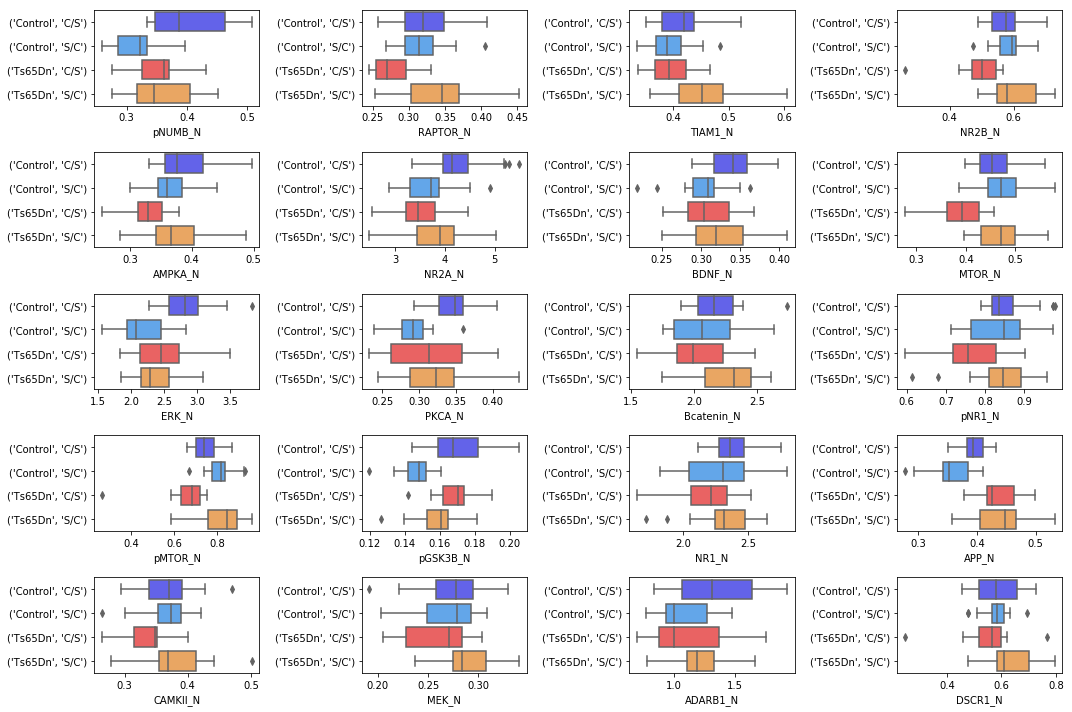

In [27]:
colors2 = [(0.3, 0.3,  1.0), #Control genotype, Learning = dark blue
          (0.3, 0.65, 1.0), #Control genotype, No learning = light blue
          (1.0, 0.3,  0.3), #Down Syndrome, Learning = red
          (1.0, 0.65, 0.3)] #Down Syndrome, No Learning = orange

_ = plt.figure(figsize = (15,10))
plot_idx = 1
v_axes2 = []
data_i2 = data.set_index(['Genotype', 'Behavior'])
for protein in candidates_gb:
    plt.subplot(5,4,plot_idx)
    v_axes.append(sns.boxplot(y = data_i2.index, x = data_i2[protein], palette = colors2, notch = False))
    v_axes[plot_idx-1].set(xticklabels=[])
    if (plot_idx % 4) != 1:
        v_axes[plot_idx-1].set(yticklabels=[])
    plot_idx += 1
_ = plt.tight_layout()

In [ ]:
#Plot an interection plot for 1 protein and 2 variables, showing mean +/- SEM
def interaction_plot(protein,variables):
    
    means = data.groupby(variables)